In [2]:
import pandas as pd 

p_full = pd.read_csv('pavement_ratings.csv')
p_full.head()

,the_geom,SegmentID,Length,Width,UsageClass,Hagstrom,Bus,Truck,Rating_B,RatingWord,RatingDate,RatingFY_S,Shape_Leng
0,MULTILINESTRING ((-74.21214990871114 40.516450...,969,589,33.08,L,0,0,0,5,FAIR,01/24/2020 12:00:00 AM,2020,609.854259
1,MULTILINESTRING ((-74.20972278371778 40.518920...,983,258,30.00,NaN,0,0,0,9,GOOD,05/20/2021 12:00:00 AM,2020,257.932162
2,MULTILINESTRING ((-74.20649118797381 40.514855...,999,232,30.00,NaN,0,0,0,3,POOR,10/01/2019 12:00:00 AM,2020,379.637985
3,MULTILINESTRING ((-74.20882121922708 40.519306...,1018,75,34.58,L,0,0,0,8,GOOD,10/01/2019 12:00:00 AM,2020,50.289164
4,MULTILINESTRING ((-74.20583882952431 40.517906...,1050,891,30.00,NaN,0,0,0,5,FAIR,01/13/2020 12:00:00 AM,2020,786.400025


In [3]:
p = p_full[
    ['the_geom', 'SegmentID', 'Rating_B', 'RatingFY_S']
].loc[p_full['RatingFY_S'].isin([2017, 2018, 2019, 2021, 2022, 2023])]

p.head()

,the_geom,SegmentID,Rating_B,RatingFY_S
5,MULTILINESTRING ((-74.1996796165617 40.5185180...,1086,9,2018
7,MULTILINESTRING ((-74.19756704522862 40.520503...,1135,8,2021
8,MULTILINESTRING ((-74.19521548161397 40.518289...,1150,7,2019
10,MULTILINESTRING ((-74.23051685807188 40.545455...,1184,8,2021
16,MULTILINESTRING ((-74.2220446196335 40.5328653...,1283,9,2018


In [4]:
schools = pd.read_csv('school_locs.csv')
schools.columns

Index(['fiscal_year', 'system_code', 'location_code', 'location_name', 'BEDS',
       'Managed_by_name', 'location_type_description',
       'Location_Category_Description', 'Grades_text', 'Grades_final_text',
       'open_date', 'Status_descriptions', 'Primary_building_code',
       'primary_address_line_1', 'State_code', 'X_COORDINATE', 'Y_COORDINATE',
       'LONGITUDE', 'LATITUDE', 'Community_district', 'Council-district',
       'Census_tract', 'Borough_block_lot', 'NTA', 'NTA_Name',
       'Principal_Name', 'Principal_title', 'Principal_phone_number',
       'fax_number', 'Geographical_District_code',
       'Administrative_District_Code', 'Administrative_District_Name',
       'community_school_sup_name', 'Tier_3_Support_Location_Name',
       'Tier_3_Support_Leader_Name', 'Tier_2_Support_Location_Name',
       'HighSchool_Network_Location_Code', 'HighSchool_Network_Name',
       'HighSchool_Network_Superintendent', 'Community_district 1',
       'Police_precinct'],
      dtype=

In [5]:
schools = schools[['location_code', 'location_name', 'LONGITUDE', 'LATITUDE', 'Police_precinct']]
schools.head()

,location_code,location_name,LONGITUDE,LATITUDE,Police_precinct
0,K001,P.S. 001 The Bergen,-74.011420,40.648959,72.0
1,K002,Parkside Preparatory Academy,-73.951575,40.656423,71.0
2,K003,P.S. 003 The Bedford Village,-73.955219,40.682311,79.0
3,K004,P.S. K004,-73.879276,40.658500,75.0
4,K005,P.S. 005 Dr. Ronald McNair,-73.921970,40.685241,81.0


In [6]:
!pip install geopandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import geopandas as gpd
import pandas as pd
from shapely.wkt import loads

filtered_p = p[p['RatingFY_S'] == 2017]

# Check for valid geometries and filter them
valid_geometries = filtered_p['the_geom'].notna() & filtered_p['the_geom'].apply(lambda x: 'MULTILINESTRING' in x)

pavement_gdf = gpd.GeoDataFrame(
    filtered_p[valid_geometries],
    geometry=[loads(geom) for geom in filtered_p.loc[valid_geometries, 'the_geom']],
    crs='EPSG:4326'
)

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools['LONGITUDE'], schools['LATITUDE']),
    crs='EPSG:4326'
)

schools_gdf['geometry'] = schools_gdf.geometry.buffer(5)

joined_gdf = gpd.sjoin(schools_gdf, pavement_gdf, how='left', predicate='intersects')

print(joined_gdf.head()) 


/tmp/ipykernel_24898/521720757.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schools_gdf['geometry'] = schools_gdf.geometry.buffer(5)


  location_code        location_name  LONGITUDE   LATITUDE  Police_precinct  \
0          K001  P.S. 001 The Bergen  -74.01142  40.648959             72.0   
0          K001  P.S. 001 The Bergen  -74.01142  40.648959             72.0   
0          K001  P.S. 001 The Bergen  -74.01142  40.648959             72.0   
0          K001  P.S. 001 The Bergen  -74.01142  40.648959             72.0   
0          K001  P.S. 001 The Bergen  -74.01142  40.648959             72.0   

                                            geometry  index_right  \
0  POLYGON ((-69.01142 40.64896, -69.0355 40.1588...       5981.0   
0  POLYGON ((-69.01142 40.64896, -69.0355 40.1588...       1204.0   
0  POLYGON ((-69.01142 40.64896, -69.0355 40.1588...       1577.0   
0  POLYGON ((-69.01142 40.64896, -69.0355 40.1588...       2333.0   
0  POLYGON ((-69.01142 40.64896, -69.0355 40.1588...       5466.0   

                                            the_geom  SegmentID  Rating_B  \
0  MULTILINESTRING ((-74.23862603

In [8]:
# Calculate average ratings for pavement segments for each school
average_ratings = (joined_gdf.groupby(['location_code', 'location_name'])
                   .agg({'Rating_B': 'mean'})
                   .rename(columns={'Rating_B': 'average_rating'})
                   .reset_index())

# Merge average ratings back to the schools GeoDataFrame
schools_with_ratings = schools_gdf.merge(average_ratings, on=['location_code', 'location_name'], how='left')

# Fill any NaN values in average_rating with 0
schools_with_ratings['average_rating'].fillna(0, inplace=True)

# Display the resulting DataFrame with relevant columns
print(schools_with_ratings[['location_code', 'location_name', 'average_rating']])


     location_code                            location_name  average_rating
0             K001                      P.S. 001 The Bergen        7.480231
1             K002             Parkside Preparatory Academy        7.480231
2             K003             P.S. 003 The Bedford Village        7.480231
3             K004                                P.S. K004        7.480231
4             K005               P.S. 005 Dr. Ronald McNair        7.480231
...            ...                                      ...             ...
2185          X729             Readnet Bronx Charter School        7.480231
2186          X730        Bronx Charter School for the Arts        7.480231
2187          X754  J. M. Rapport School Career Development        7.480231
2188          X811                                P.S. X811        7.480231
2189          X811                                P.S. X811        7.480231

[2190 rows x 3 columns]


/tmp/ipykernel_24898/1289930121.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  schools_with_ratings['average_rating'].fillna(0, inplace=True)


In [9]:
print(joined_gdf[['location_code', 'Rating_B']].drop_duplicates())
average_ratings = (joined_gdf.groupby(['location_code', 'location_name'])
                   .agg({'Rating_B': 'mean'})
                   .rename(columns={'Rating_B': 'average_rating'})
                   .reset_index())

print(average_ratings)

     location_code  Rating_B
0             K001       8.0
0             K001       6.0
0             K001       7.0
0             K001       9.0
0             K001       5.0
...            ...       ...
2188          X811       9.0
2188          X811       5.0
2188          X811       3.0
2188          X811      10.0
2188          X811       2.0

[17006 rows x 2 columns]
     location_code                            location_name  average_rating
0             K001                      P.S. 001 The Bergen        7.480231
1             K002             Parkside Preparatory Academy        7.480231
2             K003             P.S. 003 The Bedford Village        7.480231
3             K004                                P.S. K004        7.480231
4             K005               P.S. 005 Dr. Ronald McNair        7.480231
...            ...                                      ...             ...
2126          X723                                 P.S. 723        7.480231
2127          X729

In [10]:
grouped_ratings = joined_gdf.groupby('location_code')['Rating_B'].unique().reset_index()
print(grouped_ratings)

     location_code                                   Rating_B
0             K001  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
1             K002  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
2             K003  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
3             K004  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
4             K005  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
...            ...                                        ...
2126          X723  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
2127          X729  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
2128          X730  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
2129          X754  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]
2130          X811  [8.0, 6.0, 7.0, 9.0, 5.0, 3.0, 10.0, 2.0]

[2131 rows x 2 columns]


/tmp/ipykernel_24898/120101607.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pavement_gdf.buffer(50).plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
/tmp/ipykernel_24898/120101607.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


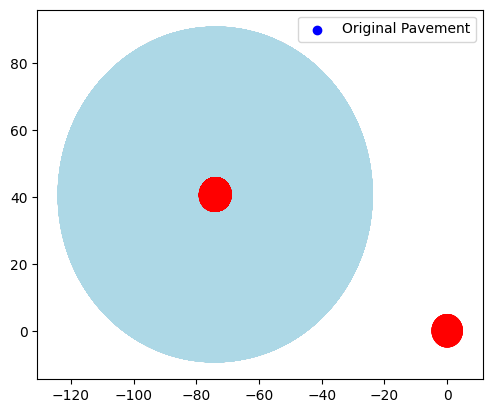

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pavement_gdf.boundary.plot(ax=ax, color='blue', label='Original Pavement')
pavement_gdf.buffer(50).plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
schools_gdf.plot(ax=ax, color='red', marker='o', label='Schools')
plt.legend()
plt.show()
